# Libraries & utilities

In [44]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import time

import pandas as pd
import numpy as np

# To enable HalvingGridSearchCV (Note: method is still experimental)
from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error
from skopt import BayesSearchCV

# Functions

In [38]:
def formatNewRow(typeOfsearch, nbr_fit, execTime, y_test, y_pred):
    new_row = {
        'typeOfSearch': typeOfsearch,
        "nbrTrains": nbr_fit,
        "executionTime": execTime,
        "rmse": root_mean_squared_error(y_test, y_pred)
    }
    return new_row

# Loading the dataset

In [39]:
data, target = fetch_california_housing(return_X_y=True, as_frame=True)
# Create the X and y DataFrames
y = target
X = data

# Train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37)

# Define search parameters

In [ ]:
# store the results
df_results = pd.DataFrame(columns=['typeOfSearch', 'nbrTrains',"executionTime", "rmse"])

# parameters to store
nbr_fits=[1,2,5]
scoring='neg_root_mean_squared_error'

# define Model
model = ElasticNet(random_state=86)

In [50]:
X_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
6229,4.0333,32.0,5.495177,1.064309,2003.0,3.220257,34.06,-117.94
12029,3.0122,16.0,4.798133,1.026838,2821.0,3.291715,33.93,-117.46
20065,2.6544,17.0,5.926554,1.045198,912.0,2.576271,38.00,-120.40
20439,4.6985,12.0,5.702055,1.027397,1577.0,2.700342,34.27,-118.80
17471,7.1687,22.0,7.615721,0.986900,1479.0,3.229258,34.46,-119.81
...,...,...,...,...,...,...,...,...
11898,8.2405,25.0,7.630573,1.006369,951.0,3.028662,33.96,-117.35
4118,3.7404,52.0,5.807531,1.133891,735.0,3.075314,34.14,-118.22
988,6.6827,13.0,6.916607,0.966211,4389.0,3.155284,37.70,-121.86
9036,3.8803,6.0,5.762493,1.046603,6163.0,3.460415,34.58,-117.78


# Pipeline

In [51]:
# numerical and categorical features for pipeline
numerical_features = list(X.columns)
# Pipeline creation
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features)
])

# Gridsearch

In [59]:
for nbr_fit in nbr_fits:
    grid_search = Pipeline([
        ('preprocessor', preprocessor),
        ('gridsearch', GridSearchCV(
            model,
            param_grid={
                "alpha" : np.logspace(0.01, 100, nbr_fit),
                "l1_ratio" : np.linspace(0.1, 1, nbr_fit)
                },
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])

    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()

    y_pred = grid_search.predict(X_test)
    new_row = formatNewRow("grid", nbr_fit * nbr_fit * grid_search["gridsearch"].n_splits_, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Random Search

In [9]:
for nbr_fit in nbr_fits:
    
    random_search = Pipeline([
        ('preprocessor', preprocessor),
        ('randomsearch', RandomizedSearchCV(
            RandomForestClassifier(max_samples=0.8, class_weight='balanced_subsample', n_jobs=-2),
            param_distributions={
                "n_estimators" : np.linspace(1, 100, dtype=int),
                "max_depth" : np.linspace(1, 15, dtype=int)
                },
            n_iter=nbr_fit * nbr_fit,
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])

    start = time.time()
    random_search.fit(X_train, y_train)
    end = time.time()

    y_pred = random_search.predict(X_test)
    new_row = formatNewRow("random", nbr_fit * nbr_fit * random_search["randomsearch"].n_splits_, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


# Halving Grid search

In [41]:
for nbr_fit in nbr_fits:
    
    halving_grid_search = Pipeline([
        ('preprocessor', preprocessor),
        ('halvinggridsearch', HalvingGridSearchCV(
            RandomForestClassifier(max_samples=0.8, class_weight='balanced_subsample', n_jobs=-2),
            param_grid={
                "n_estimators" : np.linspace(1, 100, nbr_fit, dtype=int),
                "max_depth" : np.linspace(1, 15, nbr_fit, dtype=int)
                },
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])
    
    start = time.time()
    halving_grid_search.fit(X_train, y_train)
    end = time.time()

    y_pred = halving_grid_search.predict(X_test)
    new_row = formatNewRow("halving grid", nbr_fit * nbr_fit * halving_grid_search["halvinggridsearch"].n_splits_, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 426
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 426
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 142
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 142
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 426
Fitting 5 folds for each of 2 candidates, totalling 10 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 47
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 47
Fitting 5 folds for each of 25 candidates, totalling 125 fits
----------
iter: 1
n_candidates: 9
n_resources: 141
Fitting 5 folds for each of 9 candidates, totalling 45 fits
--

# Halving random search

In [44]:
for nbr_fit in nbr_fits:
    
    halving_random_search = Pipeline([
        ('preprocessor', preprocessor),
        ('halvingrandomsearch', HalvingRandomSearchCV(
            RandomForestClassifier(max_samples=0.8, class_weight='balanced_subsample', n_jobs=-2),
            param_distributions={
                "n_estimators" : np.linspace(1, 100, dtype=int),
                "max_depth" : np.linspace(1, 15, dtype=int)
                },
            n_candidates=nbr_fit * nbr_fit,
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])
    
    start = time.time()
    halving_random_search.fit(X_train, y_train)
    end = time.time()

    y_pred = halving_grid_search.predict(X_test)
    new_row = formatNewRow("halving random", nbr_fit * nbr_fit * halving_random_search["halvingrandomsearch"].n_splits_, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 3
min_resources_: 20
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 20
Fitting 5 folds for each of 1 candidates, totalling 5 fits


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 20
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 60
Fitting 5 folds for each of 2 candidates, totalling 10 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 20
Fitting 5 folds for each of 25 candidates, totalling 125 fits
----------
iter: 1
n_candidates: 9
n_resources: 60
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 2
n_candidates: 3
n_resources: 180
Fitting 5 folds for each of 3 candidates, totalling 15 fits
n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 20
max_resources_: 426
aggressive_elimination: False
factor: 3
------

# Bayesian search

In [25]:
cv_splits = 5
for nbr_fit in nbr_fits:
    
    bayesian_search = Pipeline([
        ('preprocessor', preprocessor),
        ('bayesiansearch', BayesSearchCV(
            RandomForestClassifier(max_samples=0.8, class_weight='balanced_subsample', n_jobs=-2),
            {
                "n_estimators" : (1, 100),
                "max_depth" : (1, 15)
            },
            n_iter=nbr_fit * nbr_fit,
            cv=cv_splits,
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])

    start = time.time()
    bayesian_search.fit(X_train, y_train)
    end = time.time()

    y_pred = random_search.predict(X_test)
    new_row = formatNewRow("bayesian", nbr_fit * nbr_fit * cv_splits, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(2), np.int64(26)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(12), np.int64(60)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(13), np.int64(76)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(5), np.int64(54)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(9), np.int64(18)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(10), np.int64(47)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(12), np.int64(49)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(4), np.int64(18)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(10), np.int64(12)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(7), np.int64(32)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(1), np.int64(55)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(12), np.int64(18)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(2), np.int64(9)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(3), np.int64(63)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(15), np.int64(100)] before, using random point [np.int64(8), np.int64(44)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(13), np.int64(86)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(10), np.int64(68)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(5), np.int64(7)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(3), np.int64(6)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(10), np.int64(83)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(14), np.int64(58)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(9), np.int64(84)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(6), np.int64(100)] before, using random point [np.int64(7), np.int64(70)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(14), np.int64(44)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(2), np.int64(78)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(6), np.int64(100)] before, using random point [np.int64(6), np.int64(24)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(6), np.int64(100)] before, using random point [np.int64(15), np.int64(70)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(6), np.int64(100)] before, using random point [np.int64(2), np.int64(40)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(6), np.int64(100)] before, using random point [np.int64(5), np.int64(11)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(6), np.int64(100)] before, using random point [np.int64(13), np.int64(47)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(9), np.int64(90)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(1), np.int64(76)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(12), np.int64(98)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(5), np.int64(54)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(11), np.int64(28)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(4), np.int64(14)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(3), np.int64(60)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(12), np.int64(27)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(5), np.int64(100)] before, using random point [np.int64(6), np.int64(24)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [40]:
df_results

,typeOfSearch,nbrTrains,executionTime,accuracy,recall,precision,F1 score
0,grid,5,2.531328,0.860140,0.956989,0.847619,0.898990
1,grid,20,2.657066,0.937063,0.935484,0.966667,0.950820
2,grid,125,6.944427,0.930070,0.935484,0.956044,0.945652
3,grid,500,25.913806,0.944056,0.946237,0.967033,0.956522
4,random,5,0.833828,0.937063,0.935484,0.966667,0.950820
5,random,20,0.776838,0.958042,0.967742,0.967742,0.967742
6,random,125,7.292091,0.930070,0.935484,0.956044,0.945652
7,random,500,26.092826,0.923077,0.935484,0.945652,0.940541
19,bayesian,5,2.969000,0.923077,0.935484,0.945652,0.940541
20,bayesian,20,3.531828,0.923077,0.935484,0.945652,0.940541


# Graph

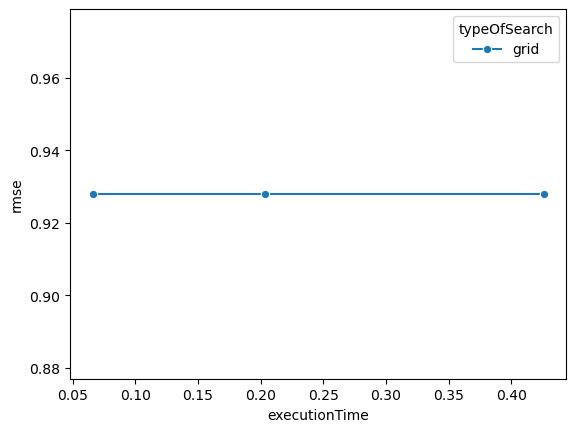

In [62]:
ax = sns.lineplot(df_results, x="executionTime", y="rmse",hue="typeOfSearch", style="typeOfSearch", markers=True, dashes=True)
plt.show()

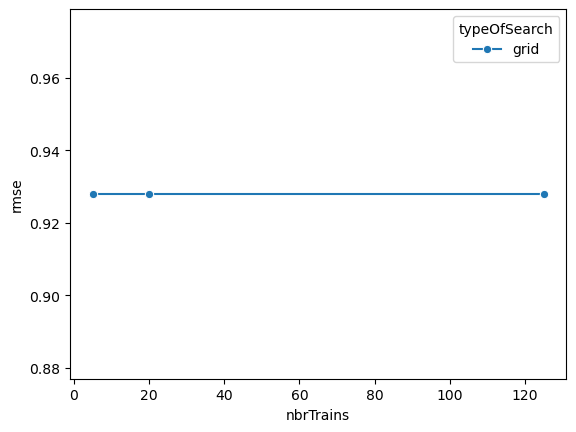

In [64]:
ax = sns.lineplot(df_results, x="nbrTrains", y="rmse",hue="typeOfSearch", style="typeOfSearch", markers=True, dashes=True)
plt.show()

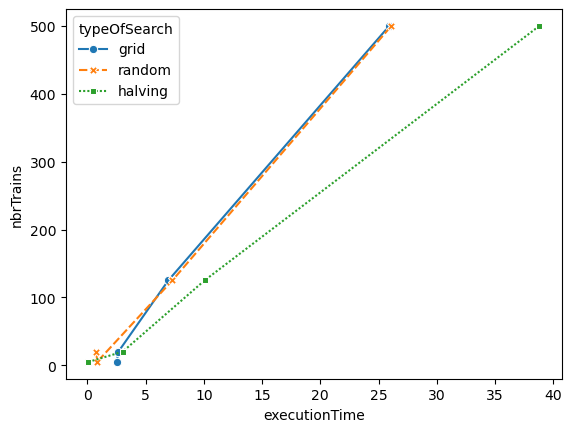

In [14]:
sns.lineplot(df_results, x="executionTime", y="nbrTrains",hue="typeOfSearch", style="typeOfSearch", markers=True, dashes=True)
plt.show()

In [57]:
df_results

,typeOfSearch,nbrTrains,executionTime,rmse
0,grid,5,0.644069,0.893912
1,grid,20,1.205702,0.893912
2,grid,125,2.685812,0.893912
3,grid,5,0.060875,0.927989
4,grid,20,0.212789,0.927989
5,grid,125,0.420169,0.927989
